## Classification

The most common supervised learning tasks are regression (predicting values) and classification (predicting classes).

We are going to look at the following topics:

 - MNIST
 - Training binary classifier
 - Performance measures
   - Measuring accuracy using cross validation
   - Confusion matrix
   - Precision and recall
   - ROC curve
 - Multiclass classification
 - Error analysis
 - Multilable classification

### Setup

Importing common modules. Using the Python3 as well as Scikit-Learn ≥0.20.

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
# %matplotlib inline : magic function  only in a Jupyter notebook to draw on screen 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
RESOURCE_DIR = os.path.join(PROJECT_ROOT_DIR, "resource")

def save_fig(fig, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(RESOURCE_DIR, fig + "." + fig_extension)
    print("Saving figure...", fig)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



#### MNIST


**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [8]:
# We will be using the MNIST dataset, which is a set of 70,000 small images of digits 
# handwritten by high school students and employees of the US Census Bureau. 
# Each image is labeled with the digit it represents.
#
# Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default. 
# To avoid this and for simplicity, use as_frame=False.

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [11]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [12]:
y.shape

(70000,)

In [13]:
# This is the pixel size of each image and there are 70,000 images.
# Each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black),
# there are 784 features.


28 * 28

784

Saving figure... some_digit_plot


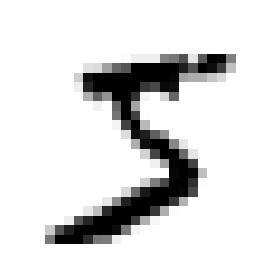

In [14]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [15]:
y[0]

'5'

In [16]:
y = y.astype(np.uint8)

In [17]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [18]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure... more_digits_plot


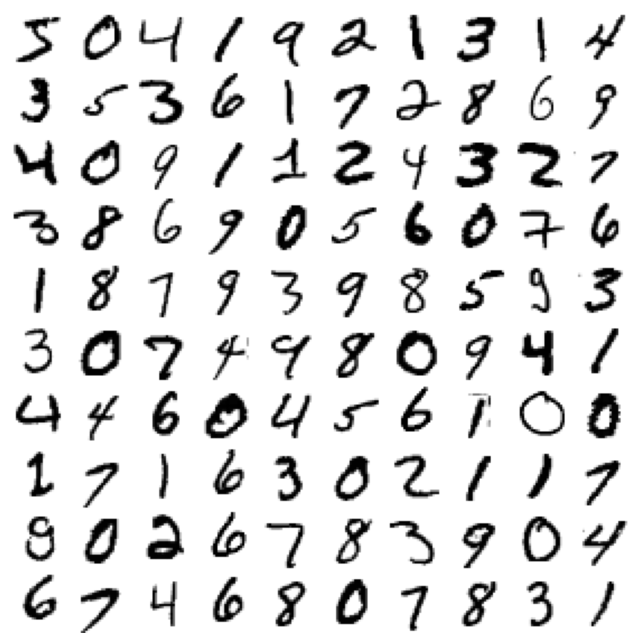

In [19]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [20]:
y[0]

5

In [21]:
# The MNIST dataset is actually already split into a training set (the first 60,000
# images) and a test set (the last 10,000 images).


X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [22]:
# We could also shuffle the data. As some learning algorithms are sensitive to the 
# order of the training instances, and they perform poorly if they get many similar 
# instances in a row. Shuffling the dataset ensures that this won’t happen.
#
# Shuffling may be a bad idea in some contexts—for example, if you are working on 
# time series data (such as stock market prices or weather conditions).


import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]



### Training a Binary Classifier


In [23]:
# Lets work on a binary classifier to detect digit "5". This “5-detector” will be 
# an example of a binary classifier, capable of distinguishing between 
# just two classes, 5 and not-5. 

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [24]:
# Lets use Scikit-Learn’s SGDClassifier class. This classifier has the advantage of 
# being capable of handling very large datasets efficiently. This is in part because 
# SGD deals with training instances independently, one at a time.


from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [25]:
sgd_clf.predict([some_digit])

array([ True])

In [26]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95635, 0.9636 , 0.96795])



### Performance measures




#### Measuring accuracy using cross-validation


In [29]:
# A somewhat custom and detailed accuracy calculation using many fold cross-validation 
# check.The Scikit-Learn’s cross_val_score() function, and prints the same result.
#
# Let’s use the cross_val_score() function to evaluate your SGDClassifier model
# using K-fold cross-validation, with three folds. Remember that K-fold 
# cross-validation means splitting the training set into K-folds (in this case, three), 
# then making predictions and evaluating them on each fold using a model trained on the
# remaining folds.


from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9646
0.9645
0.95345


In [30]:
# A dumb classifier that just classifies every single image in the “not-5” class.
# It has over 90% accuracy! This is simply because only about 10% of the
# images are 5s, so if you always guess that an image is not a 5, you will be right 
# about 90% of the time. 
#
# Which is why accuracy is generally not the preferred performance measure
# for classifiers, especially when you are dealing with skewed datasets (i.e., when some
# classes are much more frequent than others).


from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [31]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91135, 0.90965, 0.90795])



#### Confusion matrix


In [32]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [33]:
# Each row in a confusion matrix represents an actual class, while each column represents 
# a predicted class. 
# 
# The first row of this matrix considers non-5 images (the negative 
# class): 53,272 of them were correctly classified as non-5s (they are called true
# negatives), while the remaining 1,307 were wrongly classified as 5s (false positives).
# The second row considers the images of 5s (the positive class): 1,077 were wrongly
# classified as non-5s (false negatives), while the remaining 4,344 were correctly 
# classified as 5s (true positives).


from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54109,   470],
       [ 1772,  3649]])

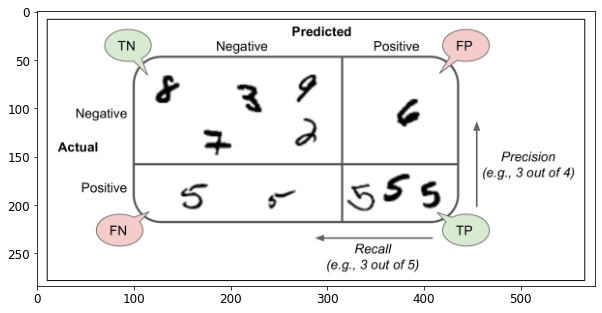

In [50]:
from matplotlib import image as mpimg

image = mpimg.imread(RESOURCE_DIR + '/confusion_mat.png')
plt.figure(figsize=(10, 10))
plt.imshow(image)

In [51]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])



#### Precision and Recall

The F 1 score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other con‐
texts you really care about recall. For example, if you trained a classifier to detect vid‐
eos that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a clas‐
sifier that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the clas‐
sifier’s video selection). On the other hand, suppose you train a classifier to detect
shoplifters on surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught).
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the precision/recall tradeoff.


In [57]:
# Now your 5-detector does not look as shiny as it did when you looked at its accuracy.
# When it claims an image represents a 5, it is correct only about 85% of the time. Moreover,
# it only detects about 68% of the 5s.


from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8858946346200534

In [58]:
# Precision is given by: TP/(TP+FP)


cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8858946346200534

In [59]:
# Recall is given by: TP/(TP+FN)

recall_score(y_train_5, y_train_pred)

0.6731230400295148

In [60]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6731230400295148

In [64]:
# It is often convenient to combine precision and recall into a single metric called 
# the F1 score, in particular if you need a simple way to compare two classifiers. 
# The F1 score is the harmonic mean of precision and recall. Whereas the regular mean
# treats all values equally, the harmonic mean gives much more weight to low values.
# As a result, the classifier will only get a high F 1 score if both recall and 
# precision are high.
#
# F1 = 2 / ((1/precision) + (1/recall)) = 2*(precision*recall/precision+recall)


from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7649895178197065

In [65]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7649895178197065



#### The ROC curve

The _receiver operating characteristic_ (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plot‐
ting precision versus recall, the ROC curve plots the _true positive rate_ (another name
for recall) against the _false positive rate_. The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called _specificity_. Hence the ROC curve plots _sensitivity_ (recall) versus
1 – _specificity_.


In [69]:
from sklearn.metrics import roc_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

NameError: name 'recall_90_precision' is not defined

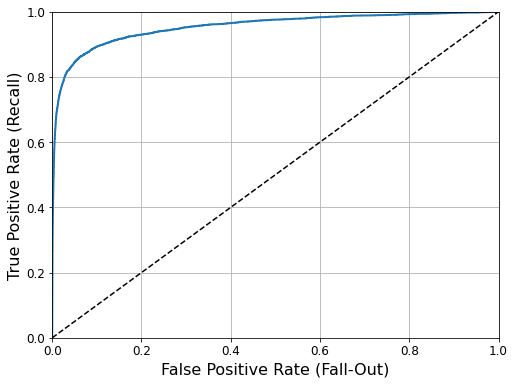

In [70]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [ ]:
# The dotted line represents the ROC curve of a purely random classifier, 
# a good classifier stays as far away from that line as possible 
# (toward the top-left corner).


recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [51]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [52]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591



### Multiclass classification


In [71]:
from sklearn.svm import SVC

#svm_clf = SVC(gamma="auto", random_state=42)
#svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
#svm_clf.predict([some_digit])

In [72]:
#some_digit_scores = svm_clf.decision_function([some_digit])
#some_digit_scores

In [73]:
#np.argmax(some_digit_scores)

In [74]:
#svm_clf.classes_

In [75]:
#svm_clf.classes_[5]

In [78]:
from sklearn.multiclass import OneVsRestClassifier
#ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
#ovr_clf.fit(X_train[:1000], y_train[:1000])
#ovr_clf.predict([some_digit])

In [79]:
#len(ovr_clf.estimators_)

In [82]:
# This code trains the SGDClassifier on the training set using the original 
# target classes from 0 to 9 ( y_train ).


sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [83]:
sgd_clf.decision_function([some_digit])

array([[-19577.47233564, -28372.79026934, -13699.97335433,
         -1010.90406358, -18826.20660092,   -117.3371993 ,
        -45097.35126277, -16117.69006955,  -9240.58470496,
        -11610.45161607]])

**Warning**: the following two cells may take close to 30 minutes to run, or more depending on your hardware.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
# Simply scaling the inputs, increases accuracy above 90%


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")



### Error analysis


In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

In [ ]:
# This confusion matrix looks fairly good, since most images are on the main diagonal,
# which means that they were classified correctly. The 5s look slightly darker than the
# other digits, which could mean that there are fewer images of 5s in the dataset or that
# the classifier does not perform as well on 5s as on other digits. In fact, you can verify
# that both are the case.


plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()